In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/')
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# For array manipulation
import numpy as np
import pandas as pd
import pandas.util.testing as tm
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
#For model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image

In [4]:
!unzip /content/drive/MyDrive/sample.zip

Archive:  /content/drive/MyDrive/sample.zip
   creating: sample/
  inflating: sample/cat24.jpg        
  inflating: sample/cat122.jpg       
  inflating: sample/cat41.jpg        
  inflating: sample/cat16.jpg        
  inflating: sample/cat20.jpg        
  inflating: sample/cat2.jpg         
  inflating: sample/cat72.jpg        
  inflating: sample/cat106.jpg       
  inflating: sample/cat120.jpg       
  inflating: sample/cat48.jpg        
  inflating: sample/cat39.jpg        
  inflating: sample/cat84.jpg        
  inflating: sample/cat124.jpg       
  inflating: sample/cat111.jpg       
  inflating: sample/cat96.jpg        
  inflating: sample/cat78.jpg        
  inflating: sample/cat77.jpg        
  inflating: sample/cat26.jpg        
  inflating: sample/cat12.jpg        
  inflating: sample/cat54.jpg        
  inflating: sample/cat43.jpg        
  inflating: sample/cat14.jpg        
  inflating: sample/cat98.jpg        
  inflating: sample/cat66.jpg        
  inflating: sample/cat

In [5]:
file_path = os.listdir('/content/sample')
print(len(file_path))

125


In [6]:
train_files, test_files = train_test_split(file_path, test_size = 0.15)
print(len(train_files))
print(len(test_files))
train_files = pd.DataFrame(train_files,columns=['filepath'])
test_files = pd.DataFrame(test_files,columns=['filepath'])
#converting into .csv file for future reference.
train_files.to_csv('/content/drive/My Drive/train_file.csv')
test_files.to_csv('/content/drive/My Drive/test_file.csv')

106
19


In [7]:
train_files = list(pd.read_csv('/content/drive/MyDrive/train_file.csv')['filepath'])
test_files = list(pd.read_csv('/content/drive/My Drive/test_file.csv')['filepath'])

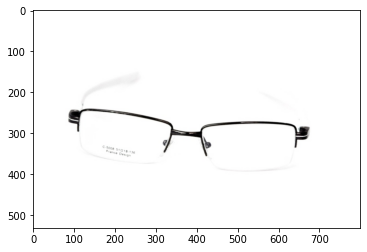

In [8]:
img = cv2.imread('/content/sample/'+train_files[10])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [9]:
type(img)

numpy.ndarray

In [10]:
def image2array(file_array):
  image_array = []
  for path in tqdm(file_array):
    img = cv2.imread('/content/sample/'+path)
    if img.shape != 0:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224,224))
      image_array.append(np.array(img))
    else:
      continue
  image_array = np.array(image_array)
  image_array = image_array.reshape(image_array.shape[0], 224, 224, 3)
  image_array = image_array.astype('float32')
  image_array /= 255
  return np.array(image_array)

In [11]:
train_data = image2array(train_files)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files)
print("Length of test dataset:",test_data.shape)

  0%|          | 0/106 [00:00<?, ?it/s]

Length of training dataset: (106, 224, 224, 3)


  0%|          | 0/19 [00:00<?, ?it/s]

Length of test dataset: (19, 224, 224, 3)


In [12]:
def encoder_decoder_model():
  #Encoder
  model = Sequential(name='Convolutional_AutoEncoder_Model')
  model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(224, 224, 3),padding='same', name='Encoding_Conv2D_1'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_1'))
  model.add(Conv2D(128, kernel_size=(3, 3),strides=1,kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu',padding='same', name='Encoding_Conv2D_2'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_2'))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_3'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', name='Encoding_MaxPooling2D_3'))
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.001), padding='same', name='Encoding_Conv2D_4'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid', name='Encoding_MaxPooling2D_4'))
  model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv2D_5'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
  #Decoder
  model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001),activation='relu', padding='same', name='Decoding_Conv2D_1'))
  model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_1'))
  model.add(Conv2D(512, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same', name='Decoding_Conv2D_2'))
  model.add(UpSampling2D((2, 2), name='Decoding_Upsamping2D_2'))
  model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer = tf.keras.regularizers.L2(0.001), activation='relu', padding='same',name='Decoding_Conv2D_3'))
  model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_3'))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_4'))
  model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_4'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.L2(0.001), padding='same',name='Decoding_Conv2D_5'))
  model.add(UpSampling2D((2, 2),name='Decoding_Upsamping2D_5'))
  model.add(Conv2D(3, kernel_size=(3, 3), padding='same',activation='sigmoid',name='Decoding_Output'))
  return model


Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_Conv2D_1 (Conv2D)   (None, 224, 224, 64)      1792      
_________________________________________________________________
Encoding_MaxPooling2D_1 (Max (None, 112, 112, 64)      0         
_________________________________________________________________
Encoding_Conv2D_2 (Conv2D)   (None, 112, 112, 128)     73856     
_________________________________________________________________
Encoding_MaxPooling2D_2 (Max (None, 56, 56, 128)       0         
_________________________________________________________________
Encoding_Conv2D_3 (Conv2D)   (None, 56, 56, 256)       295168    
_________________________________________________________________
Encoding_MaxPooling2D_3 (Max (None, 28, 28, 256)       0         
_________________________________________________________________
Encoding_Conv2D_4 (Conv2D)   (None,

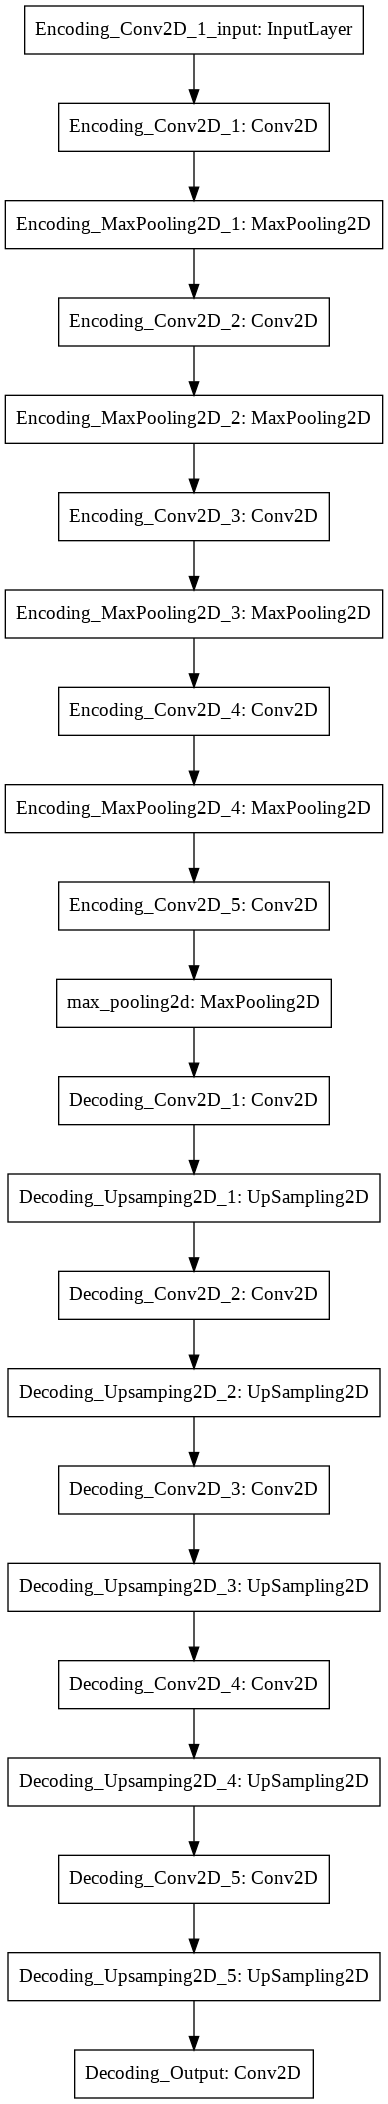

In [13]:
model = encoder_decoder_model()
model.summary()
print("\n")
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/model.png')

In [14]:
parameters = {'Adagrad':[0.01,0.001,0.0001,0.00001],'Adam':[0.01,0.001,0.0001,0.00001],'Rmsprop':[0.01,0.001,0.0001,0.00001]}
result = []
for i in parameters.keys():
    print("{} as an optimizer:".format(i))
    values = parameters[i]
    result_ = []
    for learning_rate in values:
        print("\t\tUsing learning_rate: "+str(learning_rate))
        model = encoder_decoder_model()
        if i=='Adam':
          optimizer = Adam(learning_rate=learning_rate)
        elif i=='Adagrad':
          optimizer = Adagrad(learning_rate=learning_rate)
        else:
          optimizer = RMSprop(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse') # compiling
        model.fit(train_data, train_data, epochs=5, batch_size=32,validation_data=(test_data,test_data)) # fitting data
        result_.append(model.history.history) # taking result to judge the best parameters.
    print()
    result.append(result_)

Adagrad as an optimizer:
		Using learning_rate: 0.01
Epoch 1/5
4/4 [==============================] - 52s 3s/step - loss: 2.4229 - val_loss: 2.4102
Epoch 2/5
4/4 [==============================] - 2s 519ms/step - loss: 2.4162 - val_loss: 2.4032
Epoch 3/5
4/4 [==============================] - 2s 522ms/step - loss: 2.4087 - val_loss: 2.3953
Epoch 4/5
4/4 [==============================] - 2s 527ms/step - loss: 2.4003 - val_loss: 2.3858
Epoch 5/5
4/4 [==============================] - 2s 564ms/step - loss: 2.3897 - val_loss: 2.3731
		Using learning_rate: 0.001
Epoch 1/5
4/4 [==============================] - 4s 652ms/step - loss: 2.4263 - val_loss: 2.4177
Epoch 2/5
4/4 [==============================] - 2s 524ms/step - loss: 2.4256 - val_loss: 2.4170
Epoch 3/5
4/4 [==============================] - 2s 522ms/step - loss: 2.4250 - val_loss: 2.4164
Epoch 4/5
4/4 [==============================] - 2s 523ms/step - loss: 2.4244 - val_loss: 2.4158
Epoch 5/5
4/4 [==============================] 

In [16]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):
  plt.subplot(row,col,ind)
  if isimage:
    plt.imshow(x)
    plt.title(title)
    plt.axis('off')
  else:
    plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
    if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
    plt.grid()
    plt.legend()
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

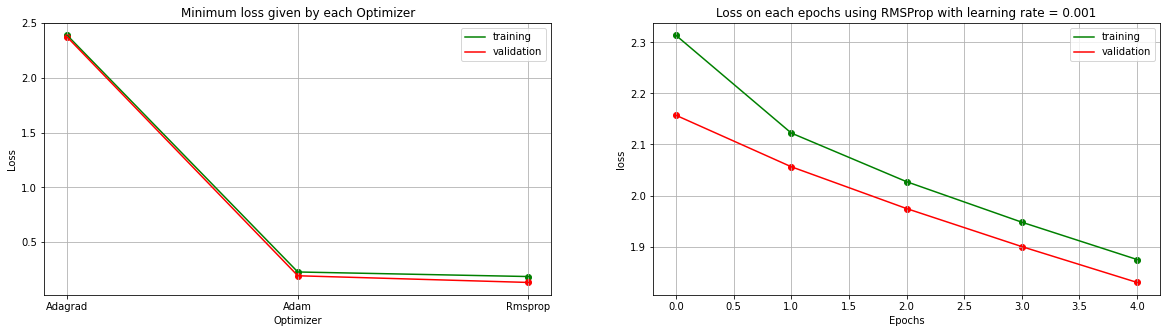

In [19]:
min_train = []; min_val = []
rates = list(parameters.keys())
epochs = [0,1,2,3,4]
for i in result:
  train = []; val = []
  for j in i:
    train.append(min(j['loss'])); val.append(min(j['val_loss'])) # taking minimum loss of each optimizer over all learning rates.
  min_train.append(min(train)); min_val.append(min(val))
plt.figure(figsize=(20,5))
plot_(rates,min_train,min_val,1,2,1,'Minimum loss given by each Optimizer','Optimizer','Loss','training',False,'r')
# plotting the result of adam with learning rate = 0.001 .
plot_(epochs, result[2][2]['loss'],result[2][2]['val_loss'],1,2,2,'Loss on each epochs using RMSProp with learning rate = 0.001','Epochs','loss','training',False,'r')
plt.show()

In [21]:
optimizer = RMSprop(learning_rate=0.001)
model = encoder_decoder_model()
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=6,min_delta=0.0001)
checkpoint = ModelCheckpoint('/content/drive/My Drive/custom_model.h5', monitor='val_loss', mode='min', save_best_only=True)
model.fit(train_data, train_data, epochs=25, batch_size=32,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint])

Epoch 1/25
4/4 [==============================] - 4s 611ms/step - loss: 1.7925 - val_loss: 0.9970
Epoch 2/25
4/4 [==============================] - 2s 521ms/step - loss: 0.8460 - val_loss: 0.5832
Epoch 3/25
4/4 [==============================] - 2s 524ms/step - loss: 0.5080 - val_loss: 0.3768
Epoch 4/25
4/4 [==============================] - 2s 521ms/step - loss: 0.3340 - val_loss: 0.2628
Epoch 5/25
4/4 [==============================] - 2s 526ms/step - loss: 0.2369 - val_loss: 0.1990
Epoch 6/25
4/4 [==============================] - 2s 529ms/step - loss: 0.1817 - val_loss: 0.1610
Epoch 7/25
4/4 [==============================] - 2s 521ms/step - loss: 0.1497 - val_loss: 0.1395
Epoch 8/25
4/4 [==============================] - 2s 531ms/step - loss: 0.1311 - val_loss: 0.1284
Epoch 9/25
4/4 [==============================] - 2s 519ms/step - loss: 0.1205 - val_loss: 0.1196
Epoch 10/25
4/4 [==============================] - 2s 528ms/step - loss: 0.1133 - val_loss: 0.1138
Epoch 11/25
4/4 [==

In [22]:
model = load_model("/content/drive/My Drive/custom_model.h5")
model.compile(optimizer=optimizer, loss='mse')

In [23]:
model.summary()

Model: "Convolutional_AutoEncoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding_Conv2D_1 (Conv2D)   (None, 224, 224, 64)      1792      
_________________________________________________________________
Encoding_MaxPooling2D_1 (Max (None, 112, 112, 64)      0         
_________________________________________________________________
Encoding_Conv2D_2 (Conv2D)   (None, 112, 112, 128)     73856     
_________________________________________________________________
Encoding_MaxPooling2D_2 (Max (None, 56, 56, 128)       0         
_________________________________________________________________
Encoding_Conv2D_3 (Conv2D)   (None, 56, 56, 256)       295168    
_________________________________________________________________
Encoding_MaxPooling2D_3 (Max (None, 28, 28, 256)       0         
_________________________________________________________________
Encoding_Conv2D_4 (Conv2D)   (None,

In [24]:
from keras import backend as K
def feature_extraction(model, data, layer = 4):
  encoded = K.function([model.layers[0].input],[model.layers[layer].output])
  encoded_array = encoded([data])[0]
  pooled_array = encoded_array.max(axis=-1)
  return encoded_array
encoded = feature_extraction(model,train_data[:10],12)

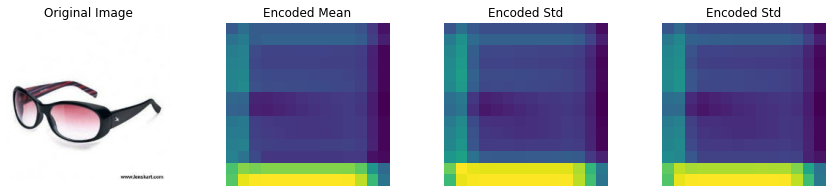

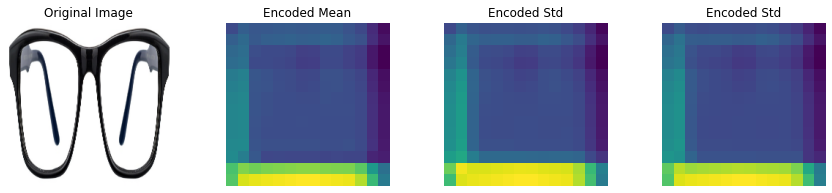

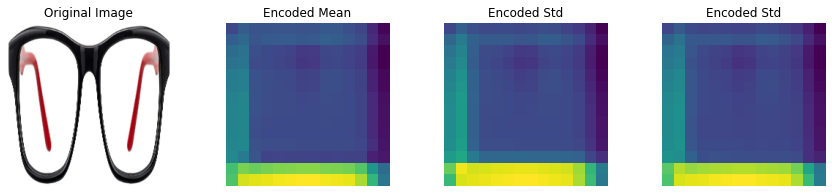

In [25]:
for index in [5, 6, 8]: # 3 random images
  plt.figure(figsize=(15,3))
  plot_(train_data[index],'','',1,4,1,"Original Image","","",'',True)
  plot_(encoded[index].mean(axis=-1),'','',1,4,2,"Encoded Mean","","",'',True)
  plot_(encoded[index].max(axis=-1),'','',1,4,3,"Encoded Std","","",'',True)
  plot_(encoded[index].std(axis=-1),'','',1,4,4,"Encoded Std","","",'',True)
  plt.show()

In [26]:
def get_batches(data, batch_size=1000):
  if len(data) < batch_size:
    return [data]
  n_batches = len(data) // batch_size
  # If batches fit exactly into the size of df.
  if len(data) % batch_size == 0:
    return [data[i*batch_size:(i+1)*batch_size] for i in range(n_batches)]
  # If there is a remainder.
  else:
    return [data[i*batch_size:min((i+1)*batch_size, len(data))] for i in range(n_batches+1)]


In [27]:
d = np.concatenate([train_data,test_data],axis=0)
d.shape

(125, 224, 224, 3)

In [28]:
X_encoded = []
i=0
for batch in get_batches(d, batch_size=300):
  i+=1
  X_encoded.append(feature_extraction(model, batch))
X_encoded = np.concatenate(X_encoded)

In [29]:
X_encoded.shape

(125, 56, 56, 256)

In [30]:
X_encoded_reshape = X_encoded.reshape(X_encoded.shape[0], X_encoded.shape[1]*X_encoded.shape[2]*X_encoded.shape[3])
print('Encoded shape:', X_encoded_reshape.shape)
np.save('/content/drive/My Drive/custom_X_encoded_compressed.npy',X_encoded_reshape)

Encoded shape: (125, 802816)


In [31]:
X_encoded = np.load('/content/drive/My Drive/custom_X_encoded_compressed.npy')
X_encoded.shape

(125, 802816)

In [32]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

125


In [33]:
transform = TSNE
trans = transform(n_components=2)
values = trans.fit_transform(X_encoded_reshape)

In [34]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='b'):

  plt.subplot(row,col,ind)
  if isimage:
    plt.imshow(x)
    plt.title(title)
    plt.axis('off')
  else:
    plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
    if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
    plt.grid()
    plt.legend()
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

In [35]:
lisp=train_files
lisp.extend(test_files)
print(len(lisp))

144


if Number of clusters: 4


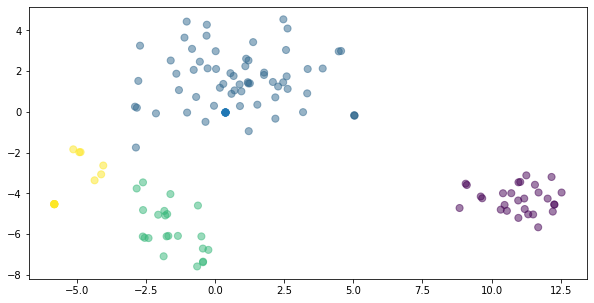

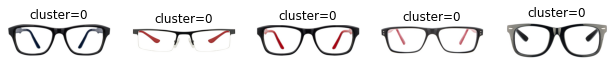

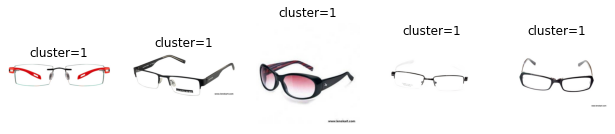

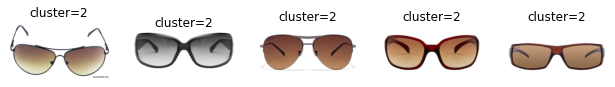

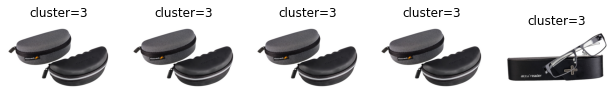


if Number of clusters: 5


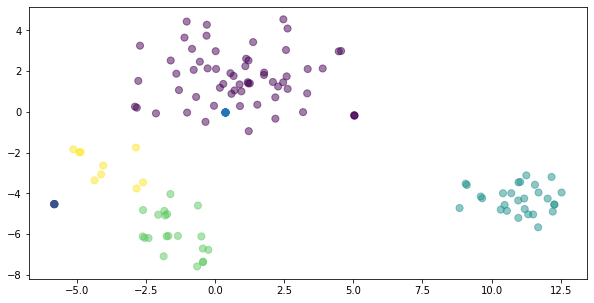

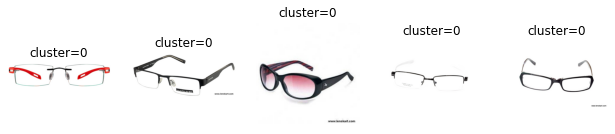

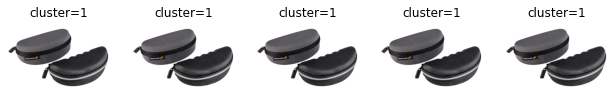

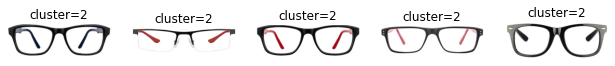

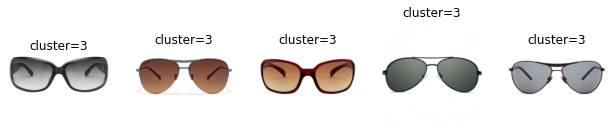

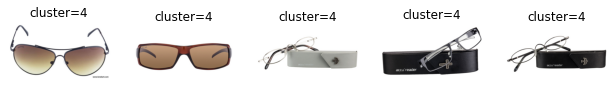


if Number of clusters: 6


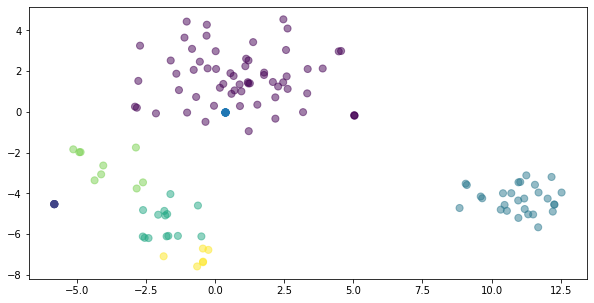

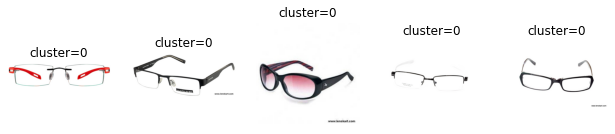

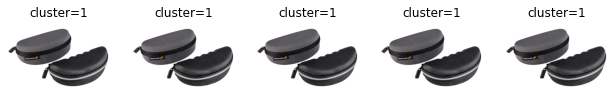

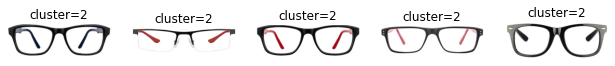

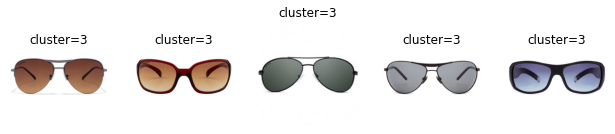

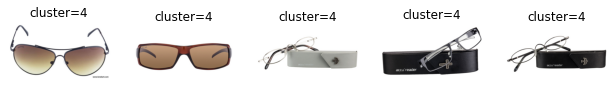

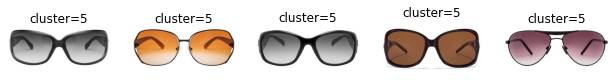


if Number of clusters: 7


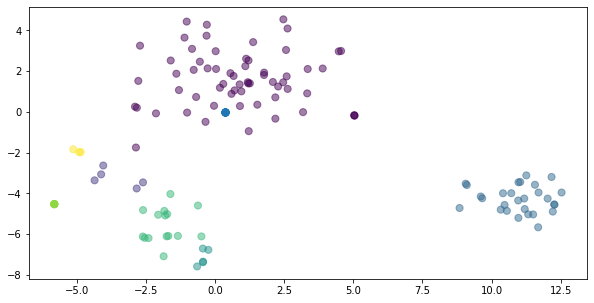

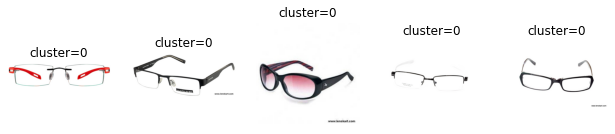

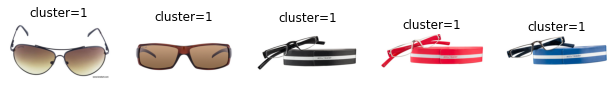

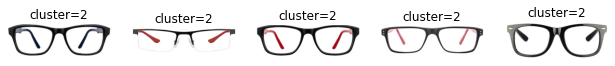

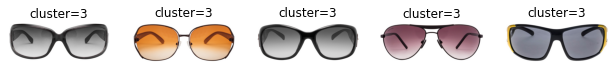

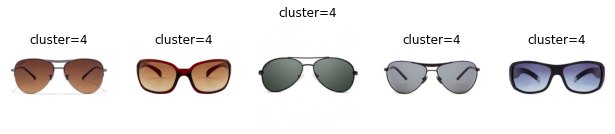

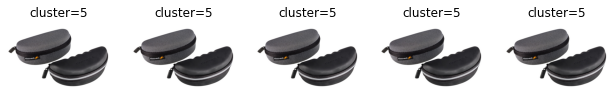

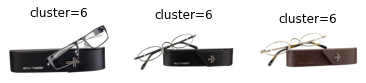

In [36]:
K = [4,5,6,7]
for k in K:
    print("if Number of clusters: "+str(k))
    kmeans = KMeans(n_clusters = k, random_state=0).fit(X_encoded_reshape)
    labels=kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10,5))
    plt.subplot(1,1,1)
    plt.scatter(values[:,0], values[:,1], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c=None, s=50)
    plt.show()
    for row in range(k):
        iter=0
        plt.figure(figsize=(13,3))
        for i,iterator in enumerate(labels):
            if iterator == row:
                img = cv2.imread("/content/sample/"+lisp[i])
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                plot_(img,"","",1,6,iter+1,"cluster="+str(row),"","","",True)
                iter+=1
            if iter>=5: break
        plt.show()
    print()

In [37]:
kmeans = KMeans(n_clusters = 6, random_state=0).fit(X_encoded_reshape)
labels=kmeans.labels_
centroids = kmeans.cluster_centers_

In [38]:
clusters_features = []
cluster_files=[]
for i in [0,1,2,3,4,5]:
  i_cluster = []
  i_labels=[]
  for iter,j in enumerate(kmeans.labels_):
      if j==i:
          i_cluster.append(X_encoded_reshape[iter])
          i_labels.append(lisp[iter])
  i_cluster = np.array(i_cluster)
  clusters_features.append(i_cluster)
  cluster_files.append(i_labels)

In [39]:
labels=[]
data=[]
files=[]
for iter,i in enumerate(clusters_features):
    data.extend(i)
    labels.extend([iter for i in range(i.shape[0])])
    files.extend(cluster_files[iter])
print(np.array(labels).shape)
print(np.array(data).shape)
print(np.array(files).shape)

(125,)
(125, 802816)
(125,)


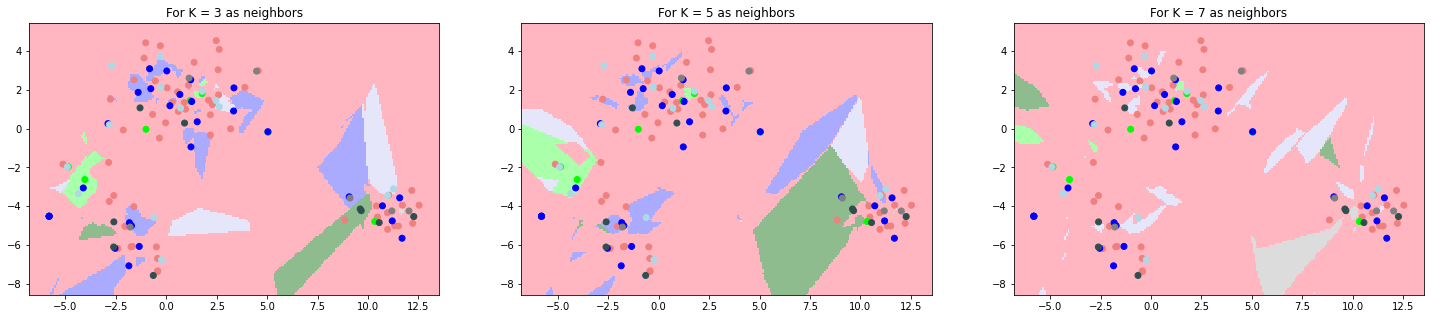

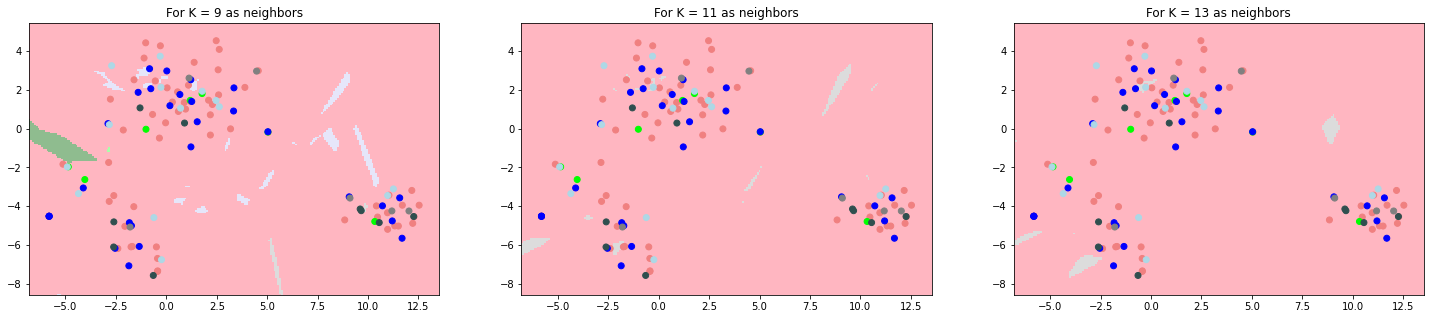

In [40]:
from matplotlib.colors import ListedColormap
for i in [[3,5,7],[9,11,13]]:
  plt.figure(figsize=(25,5))
  for iter,j in enumerate(i):
    n_neighbors = j
    X = values
    y = labels
    h = .09 # step size in the mesh
    cmap_light = ListedColormap(['#FFB6C1', '#AAFFAA', '#AAAAFF','#E6E6FA','#8FBC8F','#DCDCDC'])
    cmap_bold = ListedColormap(['#F08080', '#00FF00', '#0000FF','#ADD8E6','#2F4F4F','#808080'])
    clf = KNeighborsClassifier(n_neighbors)
    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    plt.subplot(1,3,iter+1)
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
  
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("For K = {} as neighbors".format(j))
  plt.show()

In [41]:
knn = KNeighborsClassifier(n_neighbors=11,algorithm='ball_tree',n_jobs=-1)
knn.fit(np.array(data),np.array(labels))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                     weights='uniform')

In [42]:
knn_file = '/content/drive/My Drive/custom_knn_model.pkl'
joblib.dump(knn,knn_file)

['/content/drive/My Drive/custom_knn_model.pkl']

In [43]:
def results_(query,result):
  def read(img):
    image = cv2.imread('/content/sample/'+img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image
  plt.figure(figsize=(10,5))
  if type(query)!=type(30):
    plot_(query,"","",1,1,1,"Query Image","","","",True)
  else:
    plot_(read(files[query]),"","",1,1,1,"Query Image "+files[query],"","","",True)
  plt.show()
  plt.figure(figsize=(20,5))
  for iter,i in enumerate(result):
    plot_(read(files[i]),"","",1,len(result),iter+1,files[i],"","","",True)
  plt.show()

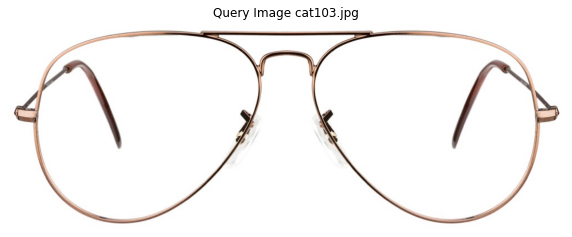

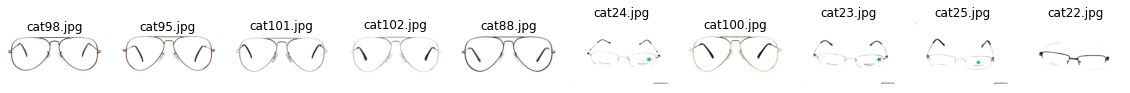

In [44]:
num = 10 #datapoint
res = knn.kneighbors(data[num].reshape(1,-1),return_distance=True,n_neighbors=11)
results_(num,list(res[1][0])[1:])

In [55]:
from keras.preprocessing import image
from keras import backend as K
def predictions(label,isurl=False):
  N = 11
  if isurl:
    img = io.imread(label)
    img = cv2.resize(img,(224,224))
  else:
    img_path = '/content/sample/'+label
    img = image.load_img(img_path, target_size=(224,224))
  img_data = image.img_to_array(img)
  img_data = np.expand_dims(img_data,axis=0)
  img_data = preprocess_input(img_data)
  feature = K.function([model.layers[0].input],
                       [model.layers[20].output])
  feature = np.array(feature).flatten().reshape(1,-1)
  res = knn.kneighbors(feature.reshape(1,-1),return_distance=True,n_neighbors=N)
  results_(img,list(res[1][0])[1:])

In [ ]:
import imageio as io
query_path = 'https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.snapdeal.com%2Fproduct%2Fspecsnlenses-red-round-spectacle-frame%2F636899285766&psig=AOvVaw36vsgBBciKnpr5OVnXlyu5&ust=1633358500539000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCNiGmt68rvMCFQAAAAAdAAAAABAD'
predictions(query_path,isurl=True)